# Compare Methods for Fitting Measurements from Experiment `20211202_72bar`

Note that the thresholds for analysis were determined based on `bubbletracking_koe/analysis/true_obj_vs_threshold.py`

In [7]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# standard libraries
import os
import glob
import pickle as pkl

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt

# custom libraries
import sys
sys.path.append('../../libs/')
import fn
import flow
import plot.bubble as pltb
from conversions import *

# comes after imports from ../../libs/ because I unfortunately 
# created files with the same name there and in ../src/
sys.path.append('../src/')
import objproc as op
import bubble
import analytics as an

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/20211202_72bar/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot Bubble Growth

Just until they start to elongate.

I plot the radius instead of the length or width because the length and width are discrete due to pixellation, whereas the fact that the radius is computed from the length and width allows it to take on more values and appear less discrete.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


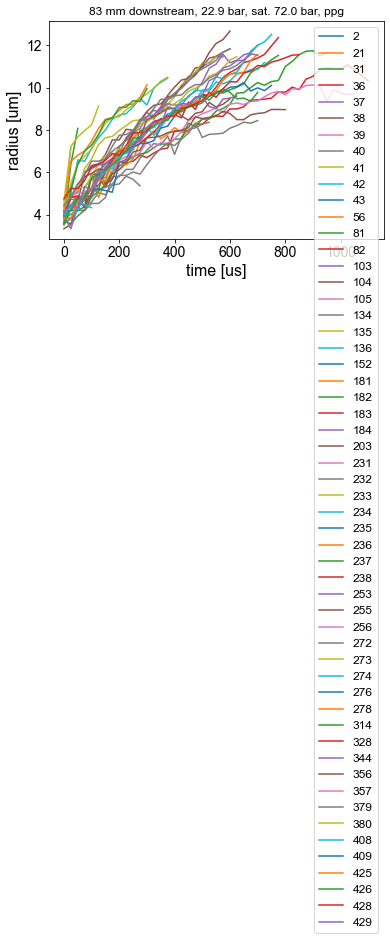

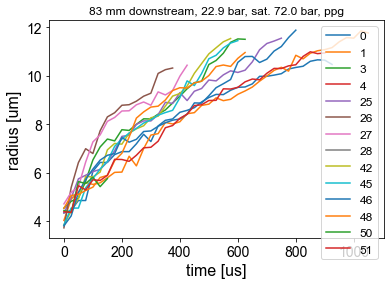

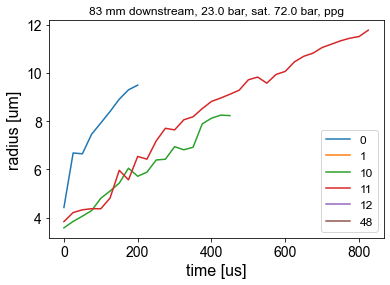

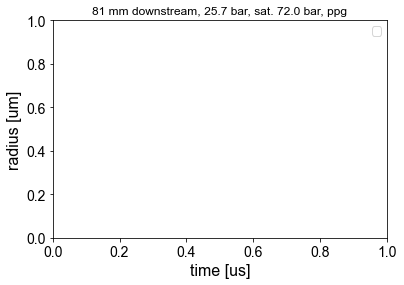

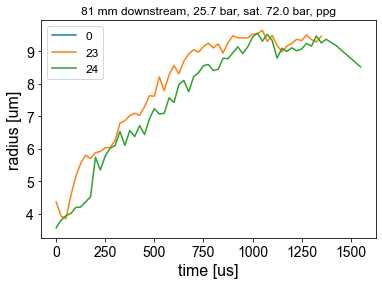

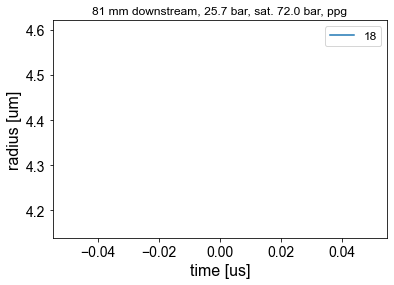

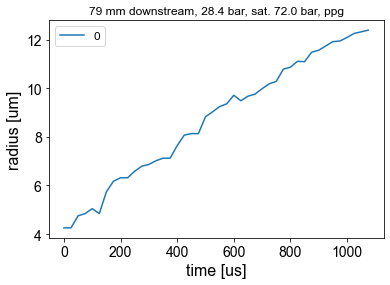

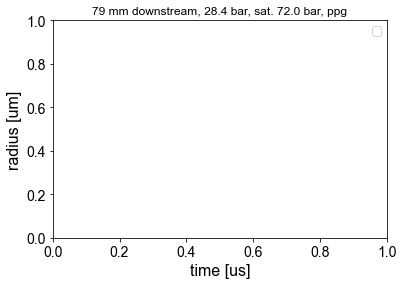

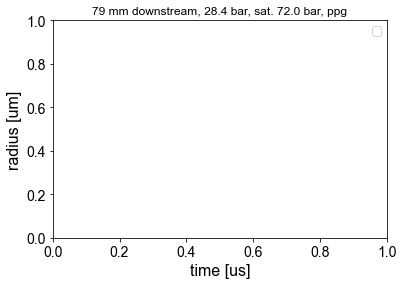

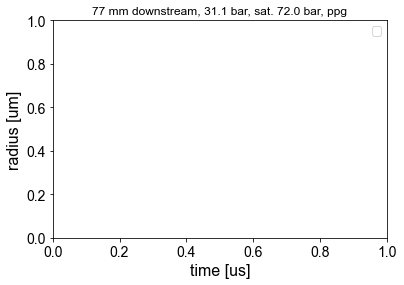

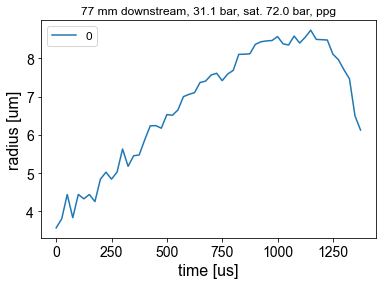

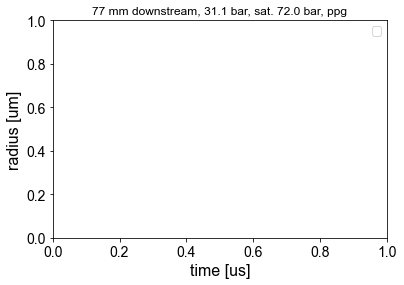

In [9]:
# plot parameters
ax_fs = 16
tk_fs = 14
l_fs = 12


# data structs to store bubble radii, etc.
# keys will be (num, ID), where num is video number and ID is bubble ID number
# values will be dictionaries of properties: time [s], radius [m], width [m], length [m],
bubble_growth = {}

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions of measurement
    p_in, p_sat, p_est, p_in, d, L, v_max, t_center, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
        
        # calculates time and radius of object
        t = op.calc_t(obj, d, v_max)  
        t -= t[0] # shifts so starts at t = 0
        R = np.asarray(obj['props_proc']['radius [um]'])
        
        # gets indices of frames where object is in early growth stages
        idx = op.get_valid_idx(obj)
        
        # plots bubble growth
        ax.plot(t[idx]*s_2_us, R[idx], label=str(ID))
        
        
    # formats plot
    ax.set_xlabel('time [us]', fontsize=ax_fs)
    ax.set_ylabel('radius [um]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.legend(fontsize=l_fs)
    ax.set_title('{0:d} mm downstream, {1:.1f} bar, sat. {2:.1f} bar, {3:s}'\
                 .format(int(d*m_2_mm), p_est*Pa_2_bar, p_sat*Pa_2_bar, polyol))

## Fit Growth to Multiple Points



Beginning analysis for single pt.


t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 94.088 ms and error in R is 2.9480.
t_nuc = 95.294 ms and error in R is 1.8483.
t_nuc = 95.897 ms and error in R is 0.9663.
t_nuc = 96.199 ms and error in R is 0.2564.
t_nuc = 96.350 ms and error in R is 0.3277.
t_nuc = 96.274 ms and error in R is 0.0034.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 96.274 ms
For D = 8e-09, exponent ratio = 1.173
t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 94.088 ms and error in R is 1.9532.
t_nuc = 95.294 ms and error in R is 1.1294.
t_nuc = 95.897 ms and error in R is 0.4751.
t_nuc = 96.199 ms and error in R is 0.0600.
t_nuc = 96.048 ms and error in R is 0.2385.
t_nuc = 96.124 ms and error in R is 0.1044.
t_nuc = 96.161 ms and error in R is 0.0210.
t_nuc = 96.180 ms and error in R is 0.0226.
t_nuc = 96.171 ms and error in R is 0.0041.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 96.171 ms
For 

t_nuc = 95.897 ms and error in R is 0.9991.
t_nuc = 95.596 ms and error in R is 0.9991.
t_nuc = 95.445 ms and error in R is 0.3401.
t_nuc = 95.370 ms and error in R is 0.2530.
t_nuc = 95.407 ms and error in R is 0.0153.
t_nuc = 95.426 ms and error in R is 0.1544.
t_nuc = 95.417 ms and error in R is 0.0732.
t_nuc = 95.412 ms and error in R is 0.0243.
t_nuc = 95.410 ms and error in R is 0.0069.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 95.410 ms
For D = 1.325e-08, exponent ratio = 1.036
t_nuc = 96.501 ms and error in R is 0.9991.
t_nuc = 94.088 ms and error in R is 3.3789.
t_nuc = 95.294 ms and error in R is 0.6088.
t_nuc = 95.897 ms and error in R is 0.9991.
t_nuc = 95.596 ms and error in R is 0.9991.
t_nuc = 95.445 ms and error in R is 0.3625.
t_nuc = 95.370 ms and error in R is 0.2406.
t_nuc = 95.407 ms and error in R is 0.0362.
t_nuc = 95.389 ms and error in R is 0.0969.
t_nuc = 95.398 ms and error in R is 0.0431.
t_nuc = 95.403 ms and error in R is 

t_nuc = 96.501 ms. Error is 0.0594 and tol is 0.0300.
t_nuc = 94.088 ms. Error is 0.2100 and tol is 0.0300.
t_nuc = 95.294 ms. Error is 0.1259 and tol is 0.0300.
t_nuc = 95.897 ms. Error is 0.0640 and tol is 0.0300.
t_nuc = 96.199 ms. Error is 0.0218 and tol is 0.0300.
Error 0.0218 is below tolerance of 0.0300 for nucleation time t = 96.199 ms
For D = 8e-09, exponent ratio 0.996 deviates from 1 by less than tolerance 0.010.
Model prediction at fit point is R = 4.932118 um.
t_nuc = 96.501 ms. Error is 0.2040 and tol is 0.0300.
t_nuc = 94.088 ms. Error is 0.1620 and tol is 0.0300.
t_nuc = 95.294 ms. Error is 0.0252 and tol is 0.0300.
Error 0.0252 is below tolerance of 0.0300 for nucleation time t = 95.294 ms
For D = 8e-09, exponent ratio = 0.689
t_nuc = 96.501 ms. Error is 0.2040 and tol is 0.0300.
t_nuc = 94.088 ms. Error is 0.2304 and tol is 0.0300.
t_nuc = 95.294 ms. Error is 0.0325 and tol is 0.0300.
t_nuc = 95.897 ms. Error is 0.1785 and tol is 0.0300.
t_nuc = 95.596 ms. Error is 0.

t_nuc = 95.294 ms. Error is 0.0435 and tol is 0.0300.
t_nuc = 95.897 ms. Error is 0.1824 and tol is 0.0300.
t_nuc = 95.596 ms. Error is 0.1154 and tol is 0.0300.
t_nuc = 95.445 ms. Error is 0.0319 and tol is 0.0300.
t_nuc = 95.370 ms. Error is 0.0196 and tol is 0.0300.
Error 0.0196 is below tolerance of 0.0300 for nucleation time t = 95.370 ms
For D = 1.36875e-08, exponent ratio = 0.877
t_nuc = 96.501 ms. Error is 0.1999 and tol is 0.0300.
t_nuc = 94.088 ms. Error is 0.2874 and tol is 0.0300.
t_nuc = 95.294 ms. Error is 0.0448 and tol is 0.0300.
t_nuc = 95.897 ms. Error is 0.1823 and tol is 0.0300.
t_nuc = 95.596 ms. Error is 0.1150 and tol is 0.0300.
t_nuc = 95.445 ms. Error is 0.0307 and tol is 0.0300.
t_nuc = 95.370 ms. Error is 0.0198 and tol is 0.0300.
Error 0.0198 is below tolerance of 0.0300 for nucleation time t = 95.370 ms
For D = 1.39062e-08, exponent ratio = 0.877
t_nuc = 96.501 ms. Error is 0.1999 and tol is 0.0300.
t_nuc = 94.088 ms. Error is 0.2892 and tol is 0.0300.
t_nu

t_nuc = 98.913 ms. Error is 0.2885 and tol is 0.0300.
t_nuc = 97.707 ms. Error is 0.2885 and tol is 0.0300.
t_nuc = 97.104 ms. Error is 0.0286 and tol is 0.0300.
Error 0.0286 is below tolerance of 0.0300 for nucleation time t = 97.104 ms
For D = 3.07812e-09, exponent ratio = 1.155
t_nuc = 96.501 ms. Error is 0.1250 and tol is 0.0300.
t_nuc = 98.913 ms. Error is 0.2885 and tol is 0.0300.
t_nuc = 97.707 ms. Error is 0.2885 and tol is 0.0300.
t_nuc = 97.104 ms. Error is 0.0306 and tol is 0.0300.
t_nuc = 96.802 ms. Error is 0.0607 and tol is 0.0300.
t_nuc = 96.953 ms. Error is 0.0251 and tol is 0.0300.
Error 0.0251 is below tolerance of 0.0300 for nucleation time t = 96.953 ms
For D = 3.02344e-09, exponent ratio = 0.834
t_nuc = 96.501 ms. Error is 0.1269 and tol is 0.0300.
t_nuc = 98.913 ms. Error is 0.2885 and tol is 0.0300.
t_nuc = 97.707 ms. Error is 0.2885 and tol is 0.0300.
t_nuc = 97.104 ms. Error is 0.0296 and tol is 0.0300.
Error 0.0296 is below tolerance of 0.0300 for nucleation t

t_nuc = 96.501 ms. Error is 0.0593 and tol is 0.0030.
t_nuc = 94.088 ms. Error is 0.2100 and tol is 0.0030.
t_nuc = 95.294 ms. Error is 0.1259 and tol is 0.0030.
t_nuc = 95.897 ms. Error is 0.0640 and tol is 0.0030.
t_nuc = 96.199 ms. Error is 0.0218 and tol is 0.0030.
t_nuc = 96.350 ms. Error is 0.0134 and tol is 0.0030.
t_nuc = 96.274 ms. Error is 0.0113 and tol is 0.0030.
t_nuc = 96.312 ms. Error is 0.0043 and tol is 0.0030.
t_nuc = 96.331 ms. Error is 0.0079 and tol is 0.0030.
t_nuc = 96.322 ms. Error is 0.0044 and tol is 0.0030.
t_nuc = 96.317 ms. Error is 0.0005 and tol is 0.0030.
Error 0.0005 is below tolerance of 0.0030 for nucleation time t = 96.317 ms
For D = 8e-09, exponent ratio = 1.318
t_nuc = 96.501 ms. Error is 0.0752 and tol is 0.0030.
t_nuc = 94.088 ms. Error is 0.1231 and tol is 0.0030.
t_nuc = 95.294 ms. Error is 0.0612 and tol is 0.0030.
t_nuc = 95.897 ms. Error is 0.0180 and tol is 0.0030.
t_nuc = 96.199 ms. Error is 0.0231 and tol is 0.0030.
t_nuc = 96.048 ms. Err

t_nuc = 95.426 ms. Error is 0.0046 and tol is 0.0030.
t_nuc = 95.436 ms. Error is 0.0042 and tol is 0.0030.
t_nuc = 95.431 ms. Error is 0.0011 and tol is 0.0030.
Error 0.0011 is below tolerance of 0.0030 for nucleation time t = 95.431 ms
For D = 1.31406e-08, exponent ratio 1.000 deviates from 1 by less than tolerance 0.010.
Model prediction at fit point is R = 4.445109 um.
t_nuc = 96.501 ms. Error is 0.1999 and tol is 0.0030.
t_nuc = 94.088 ms. Error is 0.1790 and tol is 0.0030.
t_nuc = 95.294 ms. Error is 0.0328 and tol is 0.0030.
t_nuc = 94.691 ms. Error is 0.1095 and tol is 0.0030.
t_nuc = 94.993 ms. Error is 0.0660 and tol is 0.0030.
t_nuc = 95.144 ms. Error is 0.0383 and tol is 0.0030.
t_nuc = 95.219 ms. Error is 0.0144 and tol is 0.0030.
t_nuc = 95.257 ms. Error is 0.0207 and tol is 0.0030.
t_nuc = 95.238 ms. Error is 0.0104 and tol is 0.0030.
t_nuc = 95.228 ms. Error is 0.0070 and tol is 0.0030.
t_nuc = 95.233 ms. Error is 0.0054 and tol is 0.0030.
t_nuc = 95.231 ms. Error is 0.

t_nuc = 97.047 ms. Error is 0.0056 and tol is 0.0030.
t_nuc = 97.038 ms. Error is 0.0072 and tol is 0.0030.
t_nuc = 97.042 ms. Error is 0.0032 and tol is 0.0030.
t_nuc = 97.045 ms. Error is 0.0032 and tol is 0.0030.
t_nuc = 97.044 ms. Error is 0.0001 and tol is 0.0030.
Error 0.0001 is below tolerance of 0.0030 for nucleation time t = 97.044 ms
For D = 3.1875e-09, exponent ratio 1.001 deviates from 1 by less than tolerance 0.010.
Model prediction at fit point is R = 4.158843 um.
t_nuc = 96.501 ms. Error is 0.2084 and tol is 0.0030.
t_nuc = 94.088 ms. Error is 0.1502 and tol is 0.0030.
t_nuc = 95.294 ms. Error is 0.0509 and tol is 0.0030.
t_nuc = 94.691 ms. Error is 0.0807 and tol is 0.0030.
t_nuc = 94.993 ms. Error is 0.0380 and tol is 0.0030.
t_nuc = 95.144 ms. Error is 0.0169 and tol is 0.0030.
t_nuc = 95.068 ms. Error is 0.0242 and tol is 0.0030.
t_nuc = 95.106 ms. Error is 0.0125 and tol is 0.0030.
t_nuc = 95.125 ms. Error is 0.0079 and tol is 0.0030.
t_nuc = 95.115 ms. Error is 0.0

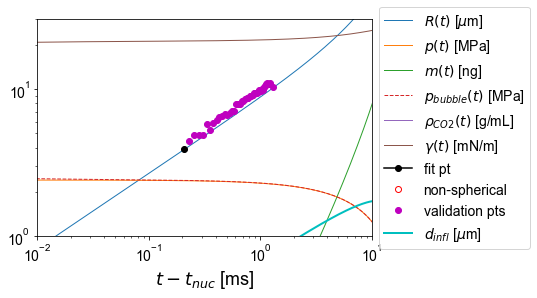

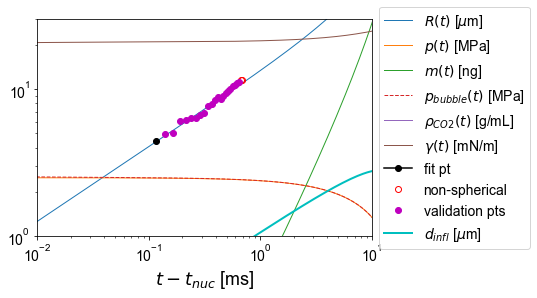

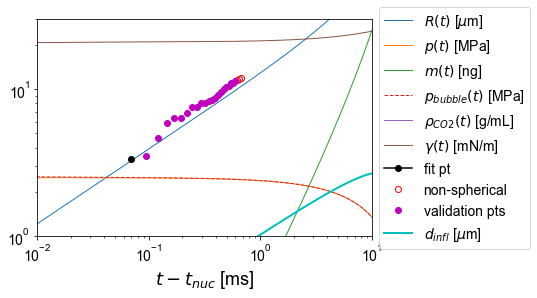

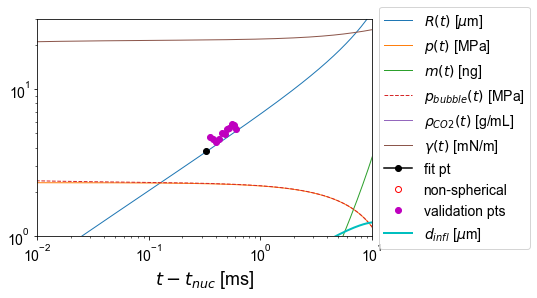

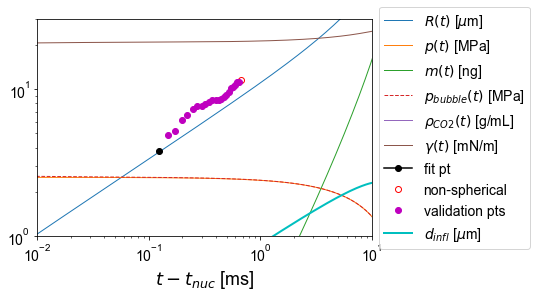

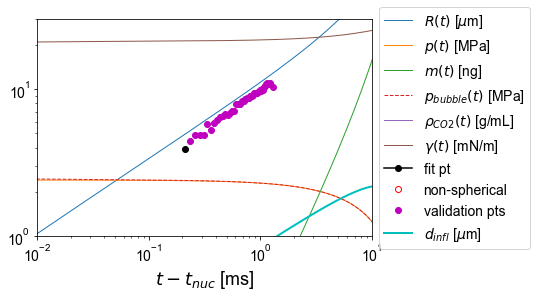

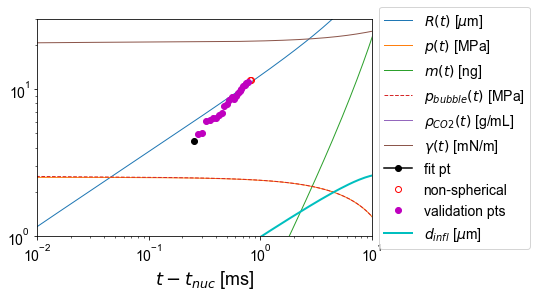

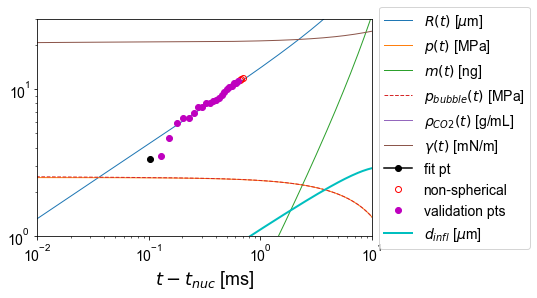

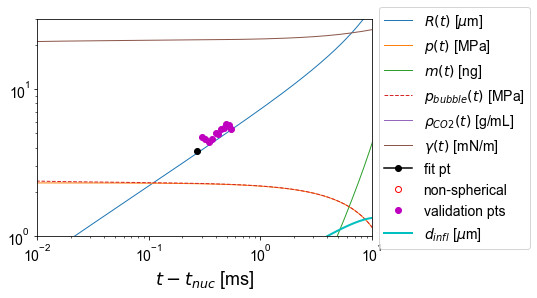

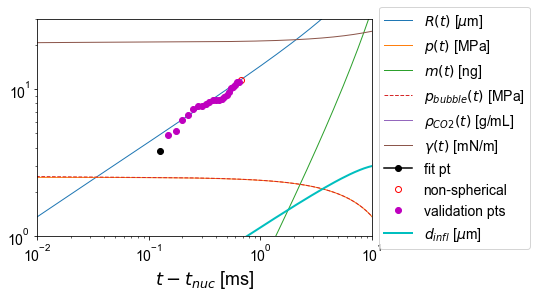

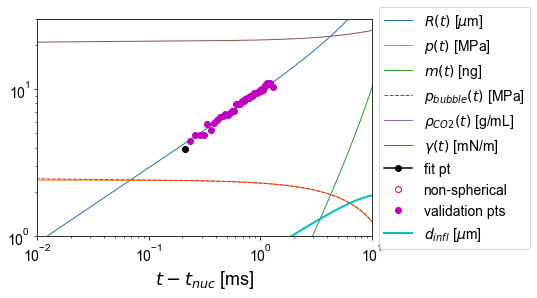

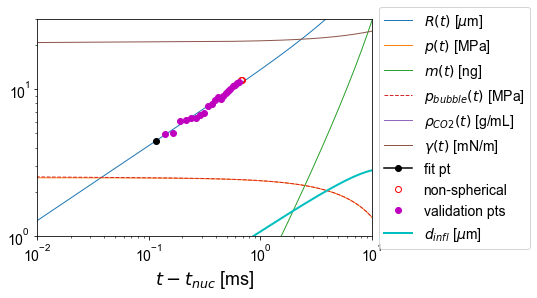

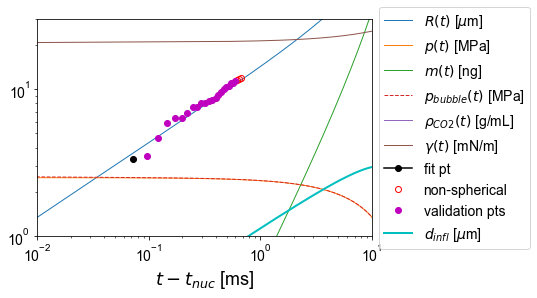

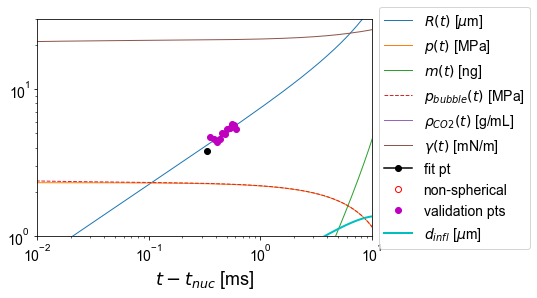

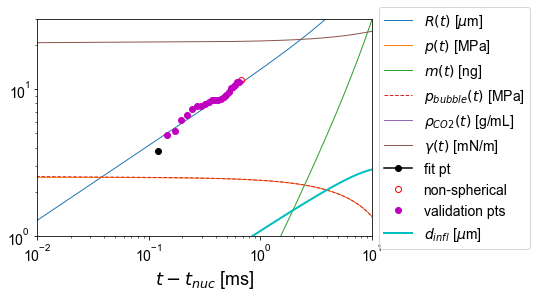

In [34]:
# GROWTH MODEL PARAMETERS
growth_fn = bubble.grow
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

# FITTING PARAMETERS
frac_lo = 0.95
frac_hi = 1.05
# guess for effective diffusivity constant [m^2/s]
D_lo = 1E-9
D_hi = 15E-9
fit_fn_params = {'err_tol' : 0.003, 'err_fn' : an.calc_abs_sgn_mse}
exp_ratio_tol = 0.01

# PLOTTING PARAMETERS
x_lim = [1E-2, 10]
y_lim = [1, 30]

# USER PARAMETERS
n_fit = 5

# globs list of data directories
data_dir_list = glob.glob(data_dir_tmp)

growth_data_dict = {}

# error tolerances
rms_err_tol = 0.03
sgn_mse_err_tol = 0.003

options = {'single pt' : {'fit_fn' : an.fit_growth_to_pt, 'fit_fn_params': {}},
          'rms' : {'fit_fn' : an.fit_growth_to_pts, 'fit_fn_params' : 
                   {'err_fn' : an.calc_rms_err, 'err_tol' : rms_err_tol}},
          'sgn mse' : {'fit_fn' : an.fit_growth_to_pts, 'fit_fn_params' :
                      {'err_fn' : an.calc_abs_sgn_mse, 'err_tol' : sgn_mse_err_tol}}
          }

for tag in options.keys():
    print('\n\nBeginning analysis for {0:s}.\n\n'.format(tag))
    params = options[tag]
    # fits effective diffusivity D and nucleation time t_nuc
    growth_data = an.fit_D_t_nuc(data_filename, data_dir_list, polyol_data_file, eos_co2_file,
                                 frac_lo, frac_hi, D_lo, D_hi, growth_fn, dt, R_nuc, 
                                 params['fit_fn_params'], exp_ratio_tol, fit_fn=params['fit_fn'],
                                 n_fit=n_fit, x_lim=x_lim, y_lim=y_lim)
    
    # stores results under tag
    growth_data_dict[tag] = growth_data

## Compare Result for Different Error Functions

Assuming that the result converges, I want to compare the finally RMS error between the prediction and the measurement.

In [35]:
tag_list = list(growth_data_dict.keys())
d_list = growth_data_dict[tag_list[0]].keys()

for d in d_list:
    vid_data_list = [growth_data_dict[tag][d] for tag in tag_list]
    for ID in vid_data_list[0].keys():
        bub_data_list = [vid_data[ID] for vid_data in vid_data_list]
        # computes RMS error for each fit method
        rms_list = [an.calc_rms_fit(bub_data) for bub_data in bub_data_list]
        
        print('Compare RMS for bubble {0:d}'.format(ID))
        print(*zip(tag_list, rms_list))
    

Compare RMS for bubble 36
('single pt', 0.016211330860875464) ('rms', 0.021750812005142686) ('sgn mse', 0.005752941995186049)
Compare RMS for bubble 37
('single pt', 0.008513044334145506) ('rms', 0.029999732824077103) ('sgn mse', 0.007877060144463566)
Compare RMS for bubble 38
('single pt', 0.026438231312542096) ('rms', 0.020004462378345036) ('sgn mse', 0.013382131038128336)
Compare RMS for bubble 40
('single pt', 0.03115116441598152) ('rms', 0.02999678170239173) ('sgn mse', 0.015318720479071941)
Compare RMS for bubble 41
('single pt', 0.04333454398130557) ('rms', 0.01721395059685952) ('sgn mse', 0.013807745403317752)


RMS error is smallest for `an.calc_abs_sgn_mse` for each of the five test bubbles. I am not surprised because its minimum value is almost always near zero (as long as the model accurately describes the dynamics). The raw RMS error grows with the noise in the measurement, which I do not have a good way to estimate. Fitting to a single point inevitably disregards the other data points and leads to higher errors.

Additionally, looking at the output of the fitting, the maximum number of iterations was only reached once for 'sgn mse' and 'single pt', while it was reached three times for 'rms'. 

### Conclusion

For now, use `an.calc_abs_sgn_mse` as the error function with `an.fit_growth_to_pts` as the fitting function.

In [36]:
# saves results for future analysis
output_dir = '../output/'

with open(os.path.join(output_dir, '20211202_bubble_fit_n5.pkl'), 'wb') as f:
    pkl.dump(growth_data_dict, f)